# Proyecto Inteligencia Artificial
Stefano Aragoni, Luis Diego Santos, Carol Arevalo

______________________

El objetivo del presente proyecto es detectar los tweets que puedan estar relacionados con cyberbulling. Para ello se descargo una base de datos de tweets del 2020. 

---------------
### Exploración y Limpieza de Datos
Como primer paso, se importa el archivo a través de distintas librerías. 

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import re

from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC

from nltk.stem import SnowballStemmer

from pandas.plotting import scatter_matrix
import pandas_profiling

from prettytable import PrettyTable

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stefanoaragoni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/stefanoaragoni/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:
#cargar dataset
data = pd.read_csv('cyberbullying_tweets.csv')

In [30]:
# Imprimir las primeras 5 filas
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [31]:
# Imprimir las últimas 5 filas
data.tail()

,tweet_text,cyberbullying_type
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity
47691,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...,ethnicity


##### Datos Faltantes
En este caso, primero se analizó si hacían falta datos en el dataset. En este caso, todos los datos estaban almacenados y no habían datos fuera de lugar.

Index([], dtype='object')

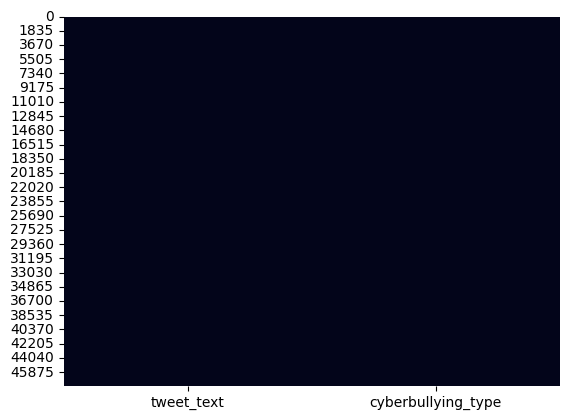

In [33]:
# Matriz de datos faltantes
sns.heatmap(data.isnull(), cbar=False)

# Mostrar columnas con datos faltantes, o con datos fuera de lugar (como un string en columna numérica)
data.columns[data.isnull().any()]

##### Datos Duplicados
Se buscaron datos dupllicados para eliminarlos y tener un modelo más exacto.


In [34]:
data['tweet_text'] = data['tweet_text'].str.lower()

#verificar datos duplicados
data.duplicated().sum()

59

In [35]:
#eliminar datos duplicados
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

##### Distribución de clases
Este tipo de análisis es útil para obtener una mejor comprensión de la distribución de los diferentes tipos de ciberacoso en los datos y para identificar los tipos de ciberacoso más comunes en un conjunto de datos.

In [37]:
# Contar la frecuencia de cada valor único en la columna "cyberbullying_type"
frecuencias = data['cyberbullying_type'].value_counts()

# Mostrar los resultados
print(frecuencias)

religion               7994
age                    7979
ethnicity              7953
gender                 7947
not_cyberbullying      7937
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64


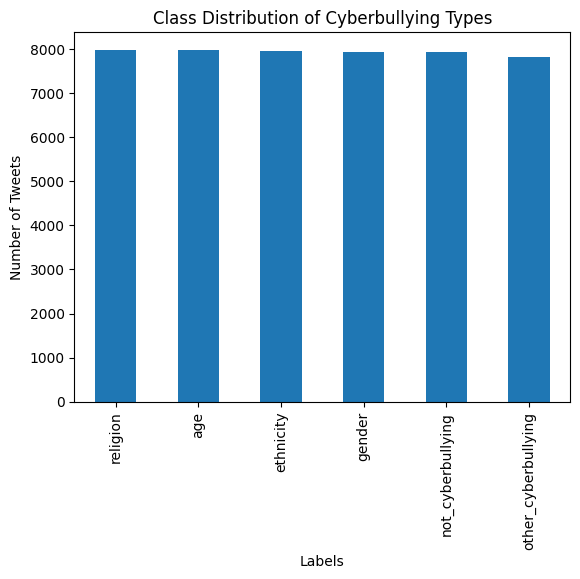

In [38]:
# Create a bar plot of the class distribution
class_counts = data['cyberbullying_type'].value_counts()
class_counts.plot(kind='bar')
plt.title('Class Distribution of Cyberbullying Types')
plt.xlabel('Labels')
plt.ylabel('Number of Tweets')
plt.show()

En este caso, las clases no están balanceadas. Por lo cual se realizará undersampling para balancear las clases.

In [39]:
from imblearn.under_sampling import RandomUnderSampler 
rus = RandomUnderSampler(random_state=42)

data2 = data['tweet_text'].to_numpy().reshape(-1, 1) # reshape data2 to have one column

# Aplicar el método de submuestreo
X_res, y_res = rus.fit_resample(data2, data['cyberbullying_type'])

# Crear un nuevo dataframe con los datos submuestreados, con los nombres de las columnas originales
data = pd.DataFrame({
    'tweet_text': X_res.flatten(),
    'cyberbullying_type': y_res
})

# Contar la frecuencia de cada valor único en la columna "cyberbullying_type"
frecuencias = data['cyberbullying_type'].value_counts()

# Mostrar los resultados
print(frecuencias)

age                    7823
ethnicity              7823
gender                 7823
not_cyberbullying      7823
other_cyberbullying    7823
religion               7823
Name: cyberbullying_type, dtype: int64


### Conteo de palabras 
A continuacion se hace un analisis de las palabras mas comunes de la base de datos. 

In [40]:
# Remover URLs, menciones y hashtags
def remove_urls_mentions_hashtags(text):
    text = re.sub(r'http\S+', '', text) # URLs
    text = re.sub(r'@\S+', '', text) # Menciones
    text = re.sub(r'#\S+', '', text) # Hashtags

    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    text = re.sub(r'[^a-zA-Z\s]', '', text) # Puntuación
    text = re.sub('<.*?>', '', text) # HTML tags

    ss = SnowballStemmer("english")
    text = ' '.join([ss.stem(word) for word in text.split()])

    return text

for i in tqdm(range(len(data))):
    data['tweet_text'][i] = remove_urls_mentions_hashtags(data['tweet_text'][i])

100%|██████████| 46938/46938 [00:42<00:00, 1097.38it/s]


In [41]:
# Frecuencia de cada palabra
tweets = ' '.join(data['tweet_text'].values)
words = tweets.split()

top_10 = Counter(words).most_common(10)

top_10

[('bulli', 10938),
 ('school', 8967),
 ('fuck', 7791),
 ('like', 6230),
 ('nigger', 5501),
 ('joke', 5461),
 ('girl', 5424),
 ('dumb', 5241),
 ('high', 4995),
 ('peopl', 4832)]

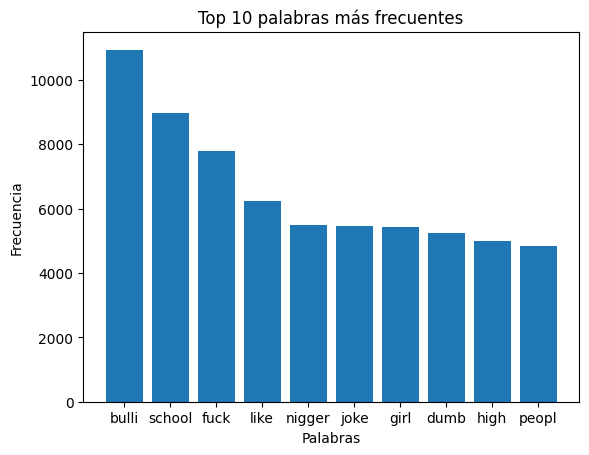

In [42]:
# diagrama de barras
plt.bar(*zip(*top_10))
plt.title('Top 10 palabras más frecuentes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.show()

-----------
## Creación de Modelos

En este caso, como primer punto se separó el dataset en tres partes: una para entrenamiento, otra para validación y otra para prueba.

Con esto en mente, se busca poder generar diferentes modelos para poder compararlos y ver cual es el que mejor se ajusta a los datos. Primero se utilizó el set de validación para, a través de GridSearchCV encontrar los mejores parametros. Posteriormente, en creación de modelos se utilizó 80% de los datos para la generación de los mismos. 


In [43]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['tweet_text']).toarray()

y = data['cyberbullying_type']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

best_models = []

### Regresion Logistica

In [45]:
param_grid = {
    'C': [0.1, 1],
    'max_iter': [1000],
}

lr = LogisticRegression()
clf = GridSearchCV(lr, param_grid, cv=5)
clf.fit(X_val, y_val)

best_lr = LogisticRegression(**clf.best_params_)
best_lr.fit(X_train, y_train)

accuracy = accuracy_score(y_test, best_lr.predict(X_test))
best_models.append(('Logistic Regression', clf.best_params_, accuracy))

print("Regresion Logistica: ", accuracy, "\n")

Regresion Logistica:  0.8195568811248403 



### Multinomial Naive Bayes

In [47]:
param_grid = {
    'fit_prior': [True, False]
}

nb = MultinomialNB()
clf = GridSearchCV(nb, param_grid, cv=5)
clf.fit(X_val, y_val)

best_nb = MultinomialNB(**clf.best_params_)
best_nb.fit(X_train, y_train)

accuracy = accuracy_score(y_test, best_nb.predict(X_test))
best_models.append(('Naive Bayes', clf.best_params_, accuracy))

print("Naive Bayes: ", accuracy, "\n")

Naive Bayes:  0.747976139752876 

